In [169]:
import pandas as pd
import numpy as np
import math

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)

from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    GridSearchCV,
    KFold
)
import joblib

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.inspection import permutation_importance

import sys
sys.path.append('../src/features')
sys.path.append('../models')
from custom_transformers import CustomTransformer
from pipeline_builder import create_pipeline, grid_search_cv

In [170]:
df = pd.read_csv('../data/raw/data.csv')
df.head() 

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,6300000.0,Secondary,Опалиха,6.0,Moscow region,1.0,30.6,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.2,20.0,10.0,6.0,15,European-style renovation
2,11090000.0,Secondary,Мякинино,14.0,Moscow region,1.0,44.7,16.2,13.1,10.0,25,Cosmetic
3,8300000.0,Secondary,Строгино,8.0,Moscow region,1.0,35.1,16.0,11.0,12.0,33,European-style renovation
4,6450000.0,Secondary,Опалиха,6.0,Moscow region,1.0,37.7,15.2,4.0,5.0,5,Without renovation


## 1. Data Exploration & Preprocessing



    Price (price):
    
The price of the apartment in the specified currency. This is the primary target variable for prediction.

    Apartment type (appartment_type):
The type of apartment, such as studio, one-bedroom, two-bedroom, etc.

    metro station (metro_station):
The name of the nearest metro station to the apartment's location.

    Minutes to metro (mins_to_metro):
The time in minutes required to walk from the apartment to the nearest metro station.

    Region (region):
The region where the apartment is located (Moscow or Moscow Oblast).

    Number of rooms (num_rooms):
The total number of rooms in the apartment, including bedrooms, living rooms, etc.

    Area (area):
The total area of the apartment in square meters.

    Living area (living_area):
The living area of the apartment in square meters, i.e., the area usable for living.

    Kitchen area (kitchen_area):
The area of the kitchen in square meters.

    Floor (floor):
The floor on which the apartment is located.

    Number of floors (num_floors):
The total number of floors in the building where the apartment is located.

    Renovation (renovation):
The level of renovation of the apartment, such as "no renovation", "cosmetic renovation", "euro renovation", etc.


In [171]:
df.describe()
# No missing values here but there are some extreme ones 
# that need to be addressed

,Price,Minutes to metro,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors
count,2.267600e+04,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000
mean,3.612132e+07,11.888605,2.043129,71.966827,38.517953,12.594082,9.190466,16.556095
std,8.282561e+07,6.204457,1.523586,68.368608,38.124278,7.728074,7.549996,9.779297
min,1.150000e+06,0.000000,0.000000,6.000000,2.000000,1.000000,1.000000,1.000000
25%,7.068116e+06,7.000000,1.000000,37.400000,17.600000,8.600000,4.000000,11.000000
50%,1.134320e+07,11.000000,2.000000,53.300000,28.500000,10.600000,8.000000,16.000000
75%,2.479925e+07,15.000000,3.000000,77.140000,43.200000,14.500000,13.000000,20.000000
max,2.455020e+09,60.000000,12.000000,1117.000000,566.800000,122.000000,92.000000,97.000000


In [172]:
df.shape

(22676, 12)

In [173]:
# Area is highly correlated with Living Area so we are keeping Area as it has
# a higher correlation with Price
df.drop('Living area', inplace=True, axis=1)

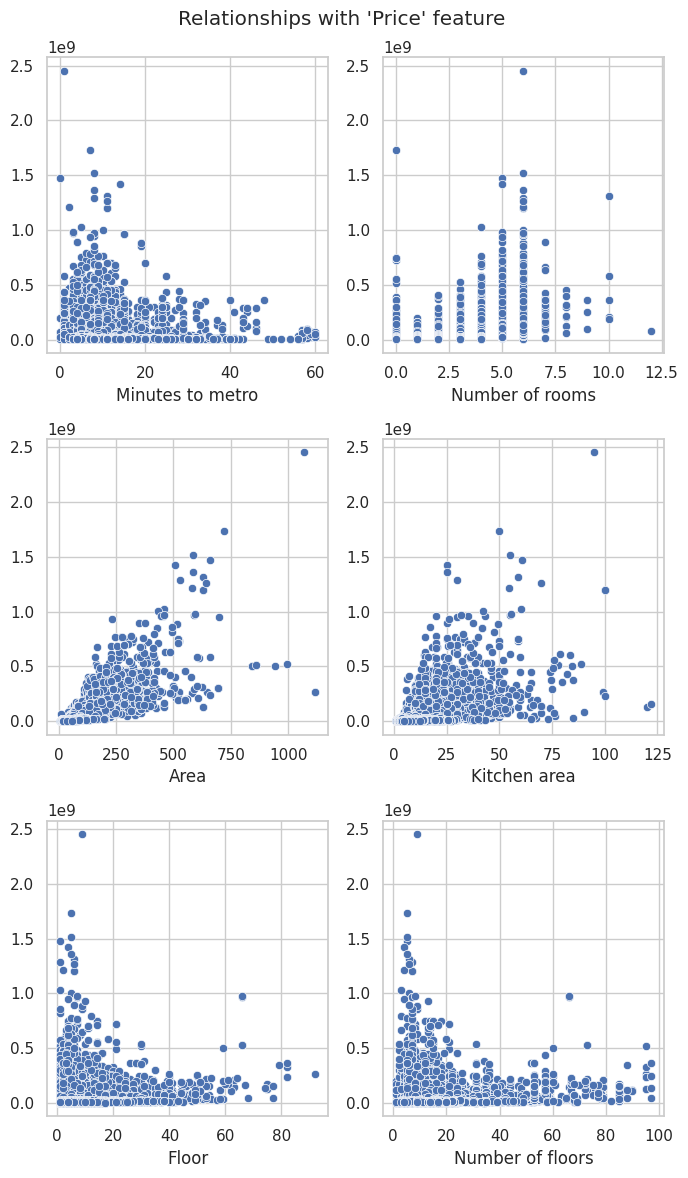

In [174]:
numerical_columns = (
    df.select_dtypes(exclude='object').drop("Price", axis=1).columns
)

nrows = math.ceil(len(numerical_columns) / 2)
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(7, nrows * 4))
fig.suptitle("Relationships with 'Price' feature")

axs = axs.flatten()

for i, category in enumerate(numerical_columns):
    sns.scatterplot(x=df[category], y=df["Price"], ax=axs[i])
    axs[i].set_xlabel(category)
    axs[i].set_ylabel('') 

if len(numerical_columns) % 2 != 0:
    fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()


In [175]:
# There seem to be little to none correlation between Floor and Number of Floors
# with target varibale

<Axes: >

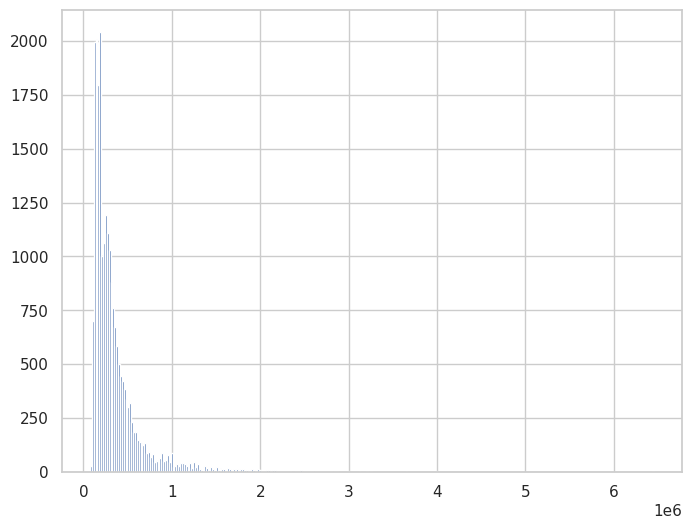

In [176]:
# Let's create a feature to see how many luxury apartments (outliers) there are
# we will kepp them for the baseline model and decide after whether to process
# them or not
df['Price per square meter'] = df['Price']/df['Area']
df['Price per square meter'].hist(bins=300, figsize=(8, 6))

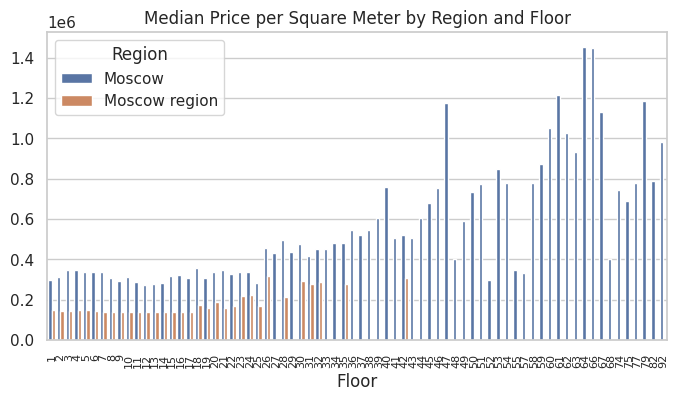

In [177]:
temp = df\
    .groupby(['Region', 'Floor'])\
    .agg({'Price per square meter': 'median'})\
    .reset_index()

temp['Floor'] = temp['Floor'].astype(int)

plt.figure(figsize=(8, 4))
sns.barplot(data=temp,
            x='Floor', 
            y='Price per square meter', 
            hue='Region')  
plt.ylabel("")
plt.xticks(fontsize=8, rotation=90)
plt.title('Median Price per Square Meter by Region and Floor')
plt.show()

In [178]:
# So Moscow has higher prices per square meter and taller buildings

In [179]:
# Let's create a new feature
df['is_penthouse'] = (df['Floor'] == df['Number of floors']) 

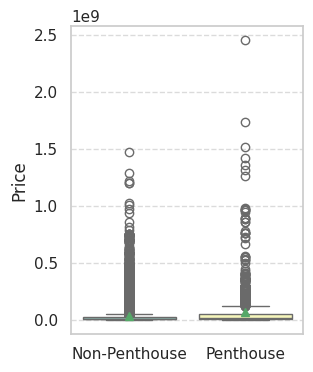

In [180]:
plt.figure(figsize=(3, 4)) 

sns.boxplot(
    x="is_penthouse",
    y='Price', 
    showmeans=True,
    data=df,
    palette="Set3"
)

plt.xlabel("")  
plt.ylabel("Price")  
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks([0, 1], ["Non-Penthouse", "Penthouse"])

plt.show()

In [181]:
df.sort_values('Minutes to metro', ascending=True).head()
# All the observations with 0s in 'Minutes to metro' column isn't mistake as
# they all are located within Moscow area which is dotted with metro stations

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Kitchen area,Floor,Number of floors,Renovation,Price per square meter,is_penthouse
5396,2.697000e+07,Secondary,Чкаловская,0.0,Moscow,1.0,41.0,20.0,8.0,21,Designer,6.578049e+05,False
4078,7.224072e+07,Secondary,Терехово,0.0,Moscow,5.0,144.8,33.2,6.0,22,Designer,4.989000e+05,False
4081,7.354392e+07,Secondary,Терехово,0.0,Moscow,5.0,144.8,33.2,8.0,22,Designer,5.079000e+05,False
3897,1.475430e+09,Secondary,Площадь Революции,0.0,Moscow,5.0,657.5,61.0,1.0,5,Designer,2.244000e+06,False
3108,7.300000e+06,Secondary,Саларьево,0.0,Moscow,0.0,28.0,5.0,4.0,13,European-style renovation,2.607143e+05,False


In [182]:
df['Number of rooms'].value_counts()
# 3233 apartments with 0 rooms? Might be studios or shared ownership apartments

Number of rooms
2.0     6342
1.0     5141
3.0     3814
0.0     3731
4.0     1957
5.0      993
6.0      652
7.0       27
8.0       10
10.0       5
9.0        3
12.0       1
Name: count, dtype: int64

In [183]:
df.describe(include='object')

,Apartment type,Metro station,Region,Renovation
count,22676,22676,22676,22676
unique,2,547,2,4
top,Secondary,Красногвардейская,Moscow,Cosmetic
freq,13152,2697,16113,12788


In [184]:
df['Metro station'].unique()

array([' Опалиха', ' Павшино', ' Мякинино', ' Строгино', ' Нахабино',
       ' Красногорская', ' Тушинская', ' Аникеевка', ' Волоколамская',
       ' Пенягино', ' Митино', ' Пятницкое шоссе', ' Чеховская',
       ' Арбатская', ' Фили', ' Белорусская', ' Кропоткинская',
       ' Спортивная', ' Алексеевская', ' Ростокино', ' Китай-город',
       ' ВДНХ', ' Динамо', ' Филатов Луг', ' Раменки', ' Минская',
       ' Аминьевская', ' Давыдково', ' Фрунзенская', ' Улица 1905 года',
       ' Кунцевская', ' Шелепиха', ' Молодёжная', ' Беговая',
       ' Бауманская', ' Славянский бульвар', ' Новокузнецкая',
       ' Парк Культуры', ' Смоленская', ' Пушкинская', ' Комсомольская',
       ' Серпуховская', ' Трубная', ' Народное Ополчение', ' Киевская',
       ' Технопарк', ' Преображенская площадь', ' Павелецкая',
       ' Красные ворота', ' Тверская', ' Петровский Парк', ' Аэропорт',
       ' Площадь Ильича', ' Краснопресненская', ' Курская',
       ' Третьяковская', ' Охотный ряд', ' Деловой центр

In [185]:
# Removing trailing empty spaces
df['Metro station'] = df['Metro station'].str.strip()

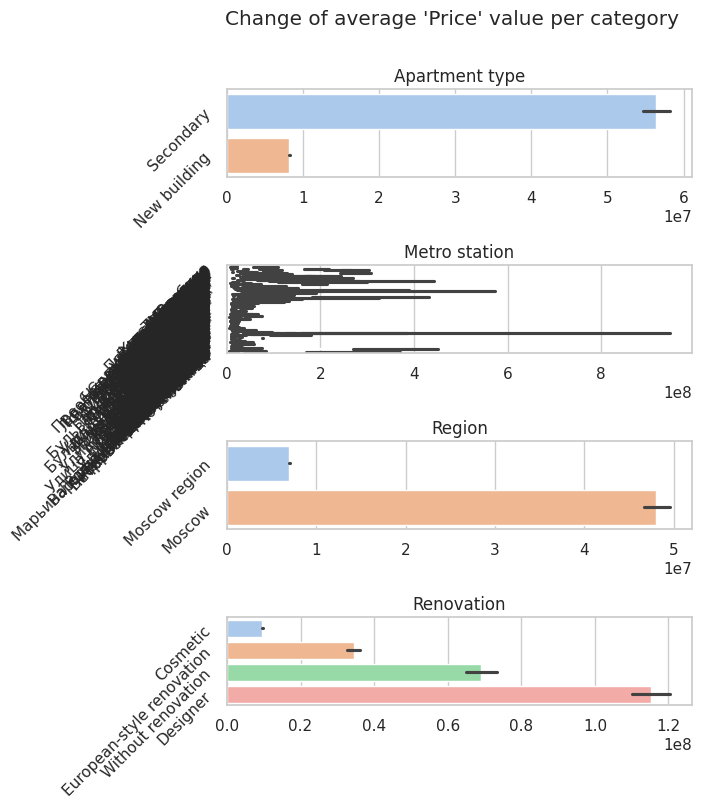

In [186]:
sns.set(style="whitegrid")

palette = sns.color_palette("pastel")

categorical_columns = df.select_dtypes(include='object').columns

nrows = len(categorical_columns)

fig, axs = plt.subplots(nrows=nrows, figsize=(6, nrows*2))
fig.suptitle("Change of average 'Price' value per category")

for i, category in enumerate(categorical_columns):
    sns.barplot(
        y=category, 
        x='Price',         
        hue=category, 
        palette=palette,
        data=df, 
        ax=axs[i])
    axs[i].set_title(category)
    axs[i].set_xlabel('') 
    axs[i].set_ylabel('')
    axs[i].tick_params(axis='y', labelrotation=45)

plt.subplots_adjust(hspace=1)

plt.show()

In [187]:
# So from a category to another one mean target variable changes which means 
# these features are important

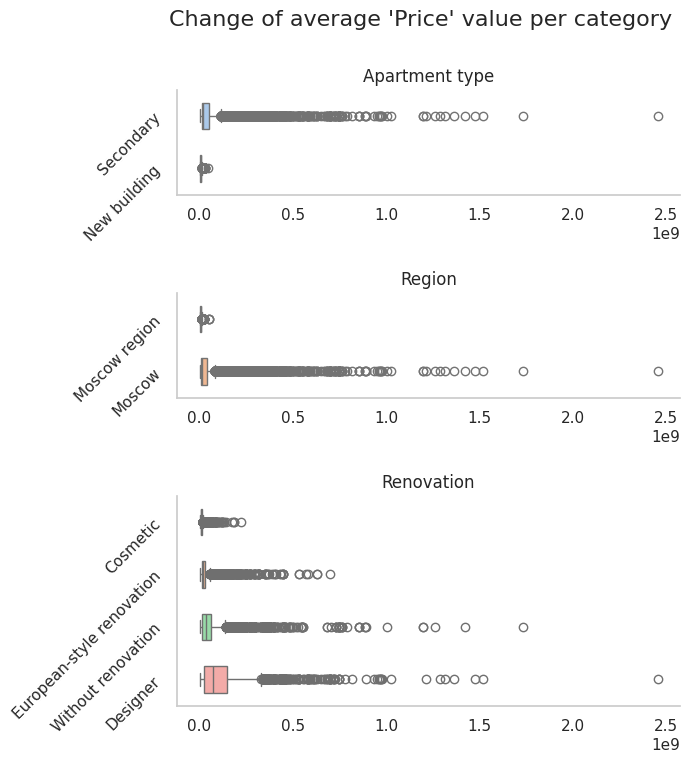

In [188]:
categorical_columns = ['Apartment type', 'Region', 'Renovation']

category_counts = df[categorical_columns].nunique()
max_count = category_counts.max()
aspect_ratios = [2 if count == max_count else 1 for count in category_counts]


fig, axs = plt.subplots(
    nrows=3, 
    figsize=(6.5, 8), 
    gridspec_kw={'height_ratios': aspect_ratios})

fig.suptitle("Change of average 'Price' value per category", fontsize=16)

for i, category in enumerate(categorical_columns):
    sns.boxplot(
        x='Price',
        y=category,
        data=df,
        ax=axs[i],
        hue=category,
        palette=palette,
        width=0.5
    )
    sns.despine(top=True, ax=axs[i]) 
    axs[i].set_title(category, fontsize=12)
    axs[i].set_ylabel('')
    axs[i].set_xlabel("")
    axs[i].tick_params(axis='y', labelrotation=45)
    axs[i].grid(False)

plt.subplots_adjust(hspace=0.7)

plt.show()

In [189]:
# These target distribution differ from category to another one, hence we gonna 
# keep them for training

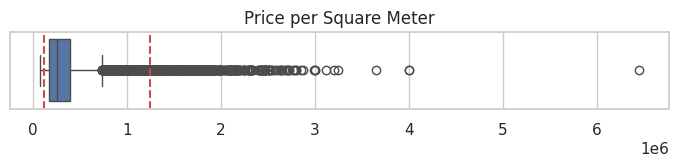

In [190]:
plt.figure(figsize=(8.5, 1)) 
sns.boxplot(data=df, x='Price per square meter')
plt.xlabel("")
plt.axvline(
    df['Price per square meter'].quantile(0.025), 
    color='r', 
    linestyle='--')
plt.axvline(
    df['Price per square meter'].quantile(0.975), 
    color='r', 
    linestyle='--')
plt.title('Price per Square Meter')
plt.show()

In [191]:
# Let's remove extremely cheap and pricey apartments as we will be focusing on
# making good prediction for common apartments

top_quantile = df['Price per square meter'].quantile(0.975)
low_quantile = df['Price per square meter'].quantile(0.025)

mask = (df['Price per square meter'] >= low_quantile)\
    & (df['Price per square meter'] <= top_quantile)

df = df[mask]
df = df.drop('Price per square meter', axis=1)

In [192]:
# Transform log price to assess MSLE

df["Price"] = np.log1p(df['Price'])
df.rename(columns={'Price': 'log_price'}, inplace=True)

In [193]:
df.head()

,log_price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Kitchen area,Floor,Number of floors,Renovation,is_penthouse
0,15.656060,Secondary,Опалиха,6.0,Moscow region,1.0,30.6,8.5,25.0,25,Cosmetic,True
1,16.012735,Secondary,Павшино,2.0,Moscow region,1.0,49.2,10.0,6.0,15,European-style renovation,False
2,16.221554,Secondary,Мякинино,14.0,Moscow region,1.0,44.7,13.1,10.0,25,Cosmetic,False
3,15.931766,Secondary,Строгино,8.0,Moscow region,1.0,35.1,11.0,12.0,33,European-style renovation,False
4,15.679591,Secondary,Опалиха,6.0,Moscow region,1.0,37.7,4.0,5.0,5,Without renovation,True


## 2. Model Training


In [194]:
X_train_val, X_test, y_train_val, y_test= train_test_split(
    df.drop('log_price', axis=1),
    df['log_price'],
    test_size=0.3, 
    random_state=42
)

numerical_columns = X_train_val.select_dtypes(include=np.number).columns.tolist()
columns_for_MTE = ['Metro station']
columns_for_OHE = ['Apartment type', 'Region', 'Renovation']

In [195]:
# Using a custom fuction to create a pipeline for our basemodel
basemodel_pipe = create_pipeline(
    LinearRegression(), 
    columns_for_MTE, 
    columns_for_OHE,
    numerical_columns
)

joblib.dump(basemodel_pipe, "../models/final_pipeline.joblib")

kfold_split = KFold(n_splits=5, shuffle=True, random_state=0)

baseline_model = cross_validate(
    basemodel_pipe, 
    X_train_val, 
    y_train_val, 
    scoring='neg_mean_squared_error',
    cv=kfold_split, 
    return_train_score=True,
    error_score='raise'
)


train_score_mean = -np.mean(baseline_model['train_score']).round(4)
validation_score_mean = -np.mean(baseline_model['test_score']).round(4)


print("Baseline model scores")
print("Train score:", train_score_mean)
print("Validation score: ", validation_score_mean)

# Baseline model scores
# Train score: 0.1003
# Validation score:  0.1031

Baseline model scores
Train score: 0.1003
Test score:  0.1031


In [196]:
# Time for fine-tuning hyperparameters
 
model_configs = {
    'OLS': {
        'model': LinearRegression,
        'params': {
            'model__fit_intercept': [True, False],
            'model__positive': [True, False]
        }
    },
    'Lasso': {
        'model': Lasso,
        'params': {
            'model__alpha': np.logspace(-4, 0, 30),
            'model__selection': ['random', 'cyclic'],
            'model__fit_intercept': [True, False],
            'model__positive': [True, False],
            'model__max_iter': [1000, 5000]
        }
    },
    'Ridge': {
        'model': Ridge,
        'params': {
            'model__alpha': np.logspace(-4, 0, 30),
            'model__fit_intercept': [True, False],
            'model__max_iter': [1000, 5000],
            'model__solver': [
                'auto', 
                'svd', 
                'cholesky',
                'lsqr',
                'sparse_cg',
                'sag',
                'saga'
            ]
        }
    }
}

results = grid_search_cv(
    X_train_val, 
    y_train_val, 
    model_configs,
    columns_for_MTE,
    columns_for_OHE,
    numerical_columns
)

In [197]:
results

[{'model': 'OLS',
  'best_score': 0.10312948402722769,
  'best_params': {'model__fit_intercept': True, 'model__positive': False}},
 {'model': 'Lasso',
  'best_score': 0.10316762991974089,
  'best_params': {'model__alpha': 0.0001,
   'model__fit_intercept': True,
   'model__max_iter': 1000,
   'model__positive': False,
   'model__selection': 'cyclic'}},
 {'model': 'Ridge',
  'best_score': 0.10312758933351422,
  'best_params': {'model__alpha': 0.0032903445623126675,
   'model__fit_intercept': True,
   'model__max_iter': 1000,
   'model__solver': 'saga'}}]

In [202]:
final_model_pipe = create_pipeline(
    Ridge(), 
    columns_for_MTE, 
    columns_for_OHE,
    numerical_columns
)

final_model_pipe.set_params(**results[2]['best_params'])

final_model_pipe.fit(X_train_val,y_train_val)

y_pred_train_val = final_model_pipe.predict(X_train_val)
y_pred_test = final_model_pipe.predict(X_test)

mse_train_validation = mean_squared_error(y_train_val, y_pred_train_val)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Final model scores")
print("Train/Validation score:", mse_train_validation.round(4))
print("Test score:            ", mse_test.round(4))

Final model scores
Train/Validation score: 0.0985
Test score:             0.1031


In [242]:
# Create a DataFrame to compare target and predicted values
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test
})

# Display the first few rows of the comparison DataFrame
print(comparison_df.head(10))

          Actual  Predicted
2168   17.989898  17.177467
6021   16.364956  16.193779
12505  16.256988  17.029689
2288   17.908187  18.226938
17580  15.531830  15.531289
22173  15.474769  15.525649
2217   17.727334  17.534043
6946   16.371962  16.435707
17585  15.383454  15.502663
18209  15.788967  15.824073


In [206]:
import pickle
import json

with open("moscow_flat_pricing_predictor.pickle","wb") as f:
    pickle.dump(final_model_pipe,f)

columns = {
    'data_columns': [col.lower() for col  in X_train_val.columns]
}

with open("columns.json","w") as f:
    f.write(json.dumps(columns))

In [244]:
np.expm1(y_test),np.expm1(y_pred_test)

(2168     65000000.0
 6021     12800000.0
 12505    11490000.0
 2288     59900000.0
 17580     5564012.0
             ...    
 7889     18400000.0
 1174     14103672.0
 3888     36663300.0
 9559     26000000.0
 17822     4715980.0
 Name: log_price, Length: 6463, dtype: float64,
 array([28845557.3423027 , 10786211.9547956 , 24882829.14566027, ...,
        36628753.40655337, 24873261.7438806 ,  4937666.98599406]))

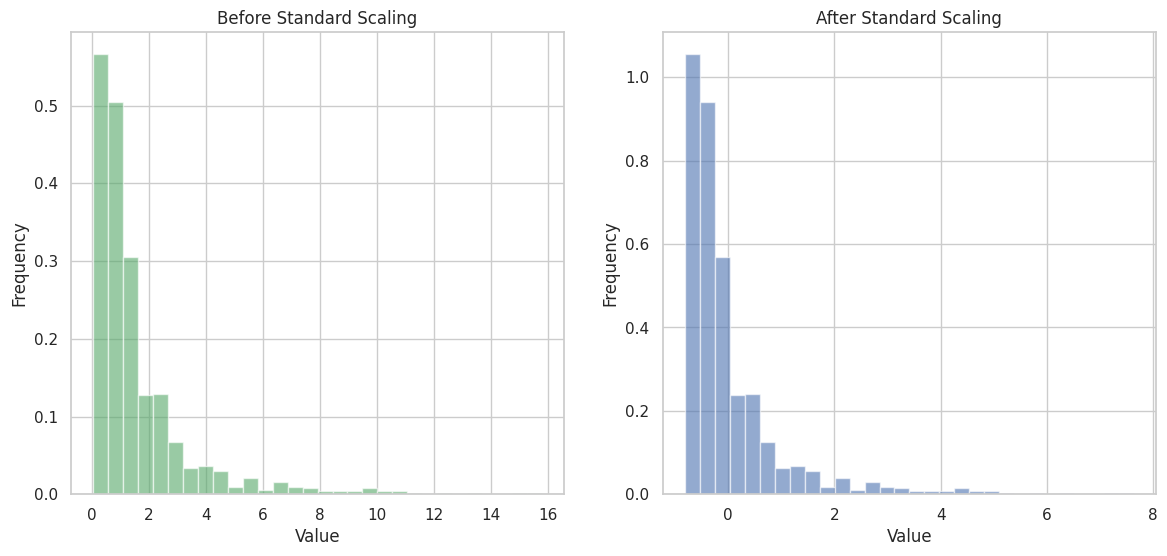

In [245]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import lognorm

# Генерация логнормального распределения
np.random.seed(0)
mu, sigma = 0, 1  # Параметры логнормального распределения
data = lognorm(s=sigma, scale=np.exp(mu)).rvs(1000)

# Создание объекта StandardScaler
scaler = StandardScaler()

# Применение стандартизации
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

# Построение графиков
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# График до стандартизации
ax[0].hist(data, bins=30, density=True, alpha=0.6, color='g')
ax[0].set_title('Before Standard Scaling')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Frequency')

# График после стандартизации
ax[1].hist(scaled_data, bins=30, density=True, alpha=0.6, color='b')
ax[1].set_title('After Standard Scaling')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Frequency')

plt.show()


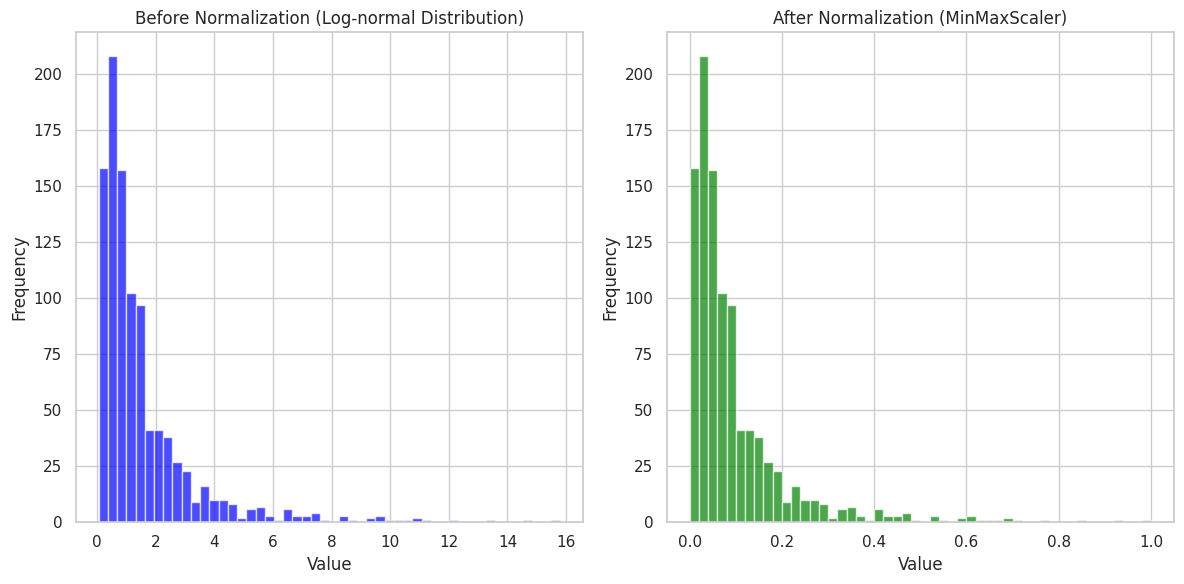

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Генерация логнормального распределения
np.random.seed(0)
data = np.random.lognormal(mean=0, sigma=1, size=1000)

# Применение MinMaxScaler
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()

# Построение графиков
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title('Before Normalization (Log-normal Distribution)')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(data_normalized, bins=50, color='green', alpha=0.7)
plt.title('After Normalization (MinMaxScaler)')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


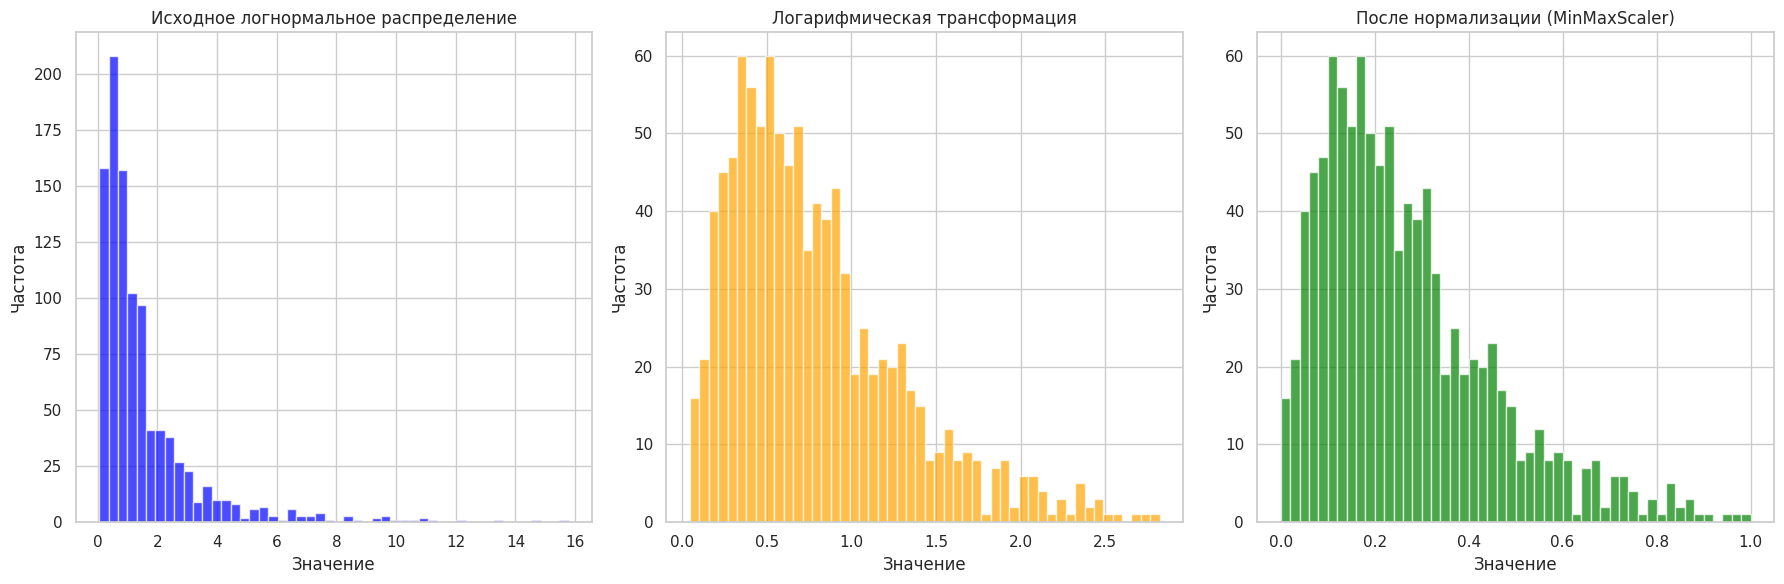

In [247]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Генерация логнормального распределения
np.random.seed(0)
data = np.random.lognormal(mean=0, sigma=1, size=1000)

# Логарифмическая трансформация
data_log_transformed = np.log1p(data)  # log(x + 1) для предотвращения логарифма от нуля

# Применение MinMaxScaler после логарифмической трансформации
scaler = MinMaxScaler()
data_log_transformed_normalized = scaler.fit_transform(data_log_transformed.reshape(-1, 1)).flatten()

# Построение графиков
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(data, bins=50, color='blue', alpha=0.7)
plt.title('Исходное логнормальное распределение')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
plt.hist(data_log_transformed, bins=50, color='orange', alpha=0.7)
plt.title('Логарифмическая трансформация')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.subplot(1, 3, 3)
plt.hist(data_log_transformed_normalized, bins=50, color='green', alpha=0.7)
plt.title('После нормализации (MinMaxScaler)')
plt.xlabel('Значение')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()
